# Laboratorio 3

Sean bienvenidos de nuevo al laboratorio 3 de Deep Learning y Sistemas Inteligentes. Así como en los laboratorios pasados, espero que esta ejercitación les sirva para consolidar sus conocimientos en el tema de Redes Neuronales Recurrentes y LSTM.

Este laboratorio consta de dos partes. En la primera trabajaremos una Red Neuronal Recurrente paso-a-paso. En la segunda fase, usaremos PyTorch para crear una nueva Red Neuronal pero con LSTM, con la finalidad de que no solo sepan que existe cierta función sino también entender qué hace en un poco más de detalle. 

Para este laboratorio estaremos usando una herramienta para Jupyter Notebooks que facilitará la calificación, no solo asegurándo que ustedes tengan una nota pronto sino también mostrandoles su nota final al terminar el laboratorio.

Espero que esta vez si se muestren los *marks*. De nuevo me discupo si algo no sale bien, seguiremos mejorando conforme vayamos iterando. Siempre pido su comprensión y colaboración si algo no funciona como debería. 

Al igual que en el laboratorio pasado, estaremos usando la librería de Dr John Williamson et al de la University of Glasgow, además de ciertas piezas de código de Dr Bjorn Jensen de su curso de Introduction to Data Science and System de la University of Glasgow para la visualización de sus calificaciones. 

**NOTA:** Ahora tambien hay una tercera dependecia que se necesita instalar. Ver la celda de abajo por favor

<script type="text/javascript" src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML">
</script>

In [1]:
# Una vez instalada la librería por favor, recuerden volverla a comentar.
#!pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master
#!pip install scikit-image
#%pip install -U --force-reinstall --no-cache https://github.com/AlbertS789/lautils/zipball/master

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import os
from collections import defaultdict

#from IPython import display
#from base64 import b64decode


# Other imports
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string, array_hash, _check_scalar
import jhwutils.image_audio as ia
import jhwutils.tick as tick
from lautils.gradeutils import new_representation, hex_to_float, compare_numbers, compare_lists_by_percentage, calculate_coincidences_percentage

###
tick.reset_marks()

%matplotlib inline

In [3]:
# Seeds
seed_ = 2023
np.random.seed(seed_)

In [4]:
# Celda escondida para utlidades necesarias, por favor NO edite esta celda


###### Información del estudiante en dos variables

* carne_1 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_1: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)
* carne_2 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_2: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)

In [5]:
carne_1 = "22309"
firma_mecanografiada_1 = "Diego Valenzuela"
carne_2 = "22281"
firma_mecanografiada_2 = "Gerson Ramirez"

In [6]:
# Deberia poder ver dos checkmarks verdes [0 marks], que indican que su información básica está OK 

with tick.marks(0): 
    assert(len(carne_1)>=5 and len(carne_2)>=5)

with tick.marks(0):  
    assert(len(firma_mecanografiada_1)>0 and len(firma_mecanografiada_2)>0)

## Parte 1 - Construyendo una Red Neuronal Recurrente

**Créditos:** La primera parte de este laboratorio está tomado y basado en uno de los laboratorios dados dentro del curso de "Deep Learning" de Jes Frellsen (DeepLearningDTU)

La aplicación de los datos secuenciales pueden ir desde predicción del clima hasta trabajar con lenguaje natural. En este laboratorio daremos un vistazo a como las RNN pueden ser usadas dentro del modelaje del lenguaje, es decir, trataremos de predecir el siguiente token dada una secuencia. En el campo de NLP, un token puede ser un caracter o bien una palabra.

### Representanción de Tokens o Texto

Como bien hemos hablado varias veces, la computadora no entiende palabras ni mucho menos oraciones completas en la misma forma que nuestros cerebros lo hacen. Por ello, debemos encontrar alguna forma de representar palabras o caracteres en una manera que la computadora sea capaz de interpretarla, es decir, con números. Hay varias formas de representar un grupo de palabras de forma numérica, pero para fines de este laboratorio vamos a centrarnos en una manera común, llamada "one-hot encoding". 

#### One Hot Encoding
Esta técnica debe resultarles familiar de cursos pasados, donde se tomaba una conjunto de categorías y se les asignaba una columna por categoría, entonces se coloca un 1 si el row que estamos evaluando es parte de esa categoría o un 0 en caso contrario. Este mismo acercamiento podemos tomarlo para representar conjuntos de palabras. Por ejemplo

```
casa = [1, 0, 0, ..., 0]
perro = [0, 1, 0, ..., 0]
```

Representar un vocabulario grande con one-hot enconding, suele volverse ineficiente debido al tamaño de cada vector disperso. Para solventar esto, una práctica común es truncar el vocabulario para contener las palabras más utilizadas y representar el resto con un símbolo especial, UNK, para definir palabras "desconocidas" o "sin importancia". A menudo esto se hace que palabras tales como nombres se vean como UNK porque son raros.

### Generando el Dataset a Usar

Para este laboratorio usaremos un dataset simplificado, del cual debería ser más sencillo el aprender de él. Estaremos generando secuencias de la forma

```
a b EOS
a a a a b b b b EOS
```

Noten la aparición del token "EOS", el cual es un caracter especial que denota el fin de la secuencia. Nuestro task en general será el predecir el siguiente token $t_n$, donde este podrá ser "a", "b", "EOS", o "UNK" dada una secuencia de forma ${t_1 , ... , t_{n-1}}$.

In [7]:
# Reseed the cell
np.random.seed(seed_)

def generate_data(num_seq=100):
    """
    Genera un grupo de secuencias, la cantidad de secuencias es dada por num_seq
    
    Args:
    num_seq: El número de secuencias a ser generadas
    
    Returns:
    Una lista de secuencias
    """
    samples = []
    for i in range(num_seq):
        # Genera una secuencia de largo aleatorio
        num_tokens = np.random.randint(1,12) 
        # Genera la muestra
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        # Agregamos
        samples.append(sample)
    return samples

sequences = generate_data()
print("Una secuencia del grupo generado")
print(sequences[0])

Una secuencia del grupo generado
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


### Representación de tokens como índices

En este paso haremos la parte del one-hot encoding. Para esto necesitaremos asignar a cada posible palabra de nuestro vocabulario un índice. Para esto crearemos dos diccionarios, uno que permitirá que dada una palabra nos dirá su representación como "indice" en el vocabulario, y el segundo que irá en dirección contraria. 

A estos les llamaremos `word_to_idx` y `idx_to_word`. La variable `vocab_size` nos dirá el máximo de tamaño de nuestro vocabulario. Si intentamos acceder a una palabra que no está en nuestro vocabulario, entonces se le reemplazará con el token "UNK" o su índice correspondiente.

In [8]:
def seqs_to_dicts(sequences):
    """
    Crea word_to_idx y idx_to_word para una lista de secuencias
    
    Args:
    sequences: lista de secuencias a usar
    
    Returns:
    Diccionario de palabra a indice
    Diccionario de indice a palabra
    Int numero de secuencias
    Int tamaño del vocabulario
    """
    
    # Lambda para aplanar (flatten) una lista de listas
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # Aplanamos el dataset
    all_words = flatten(sequences)
    
    # Conteo de las ocurrencias de las palabras
    word_count = defaultdict(int)
    for word in all_words:
        word_count[word] += 1
        
    # Ordenar por frecuencia
    word_count = sorted(list(word_count.items()), key=lambda x: -x[1])
    
    # Crear una lista de todas las palabras únicas
    unique_words = [w[0] for w in word_count]
    
    # Agregamos UNK a la lista de palabras
    unique_words.append("UNK")
    
    # Conteo del número de secuencias y el número de palabras unicas
    num_sentences, vocab_size = len(sequences), len(unique_words)
    
    # Crear diccionarios mencionados
    word_to_idx = defaultdict(lambda: vocab_size-1)
    idx_to_word = defaultdict(lambda: 'UNK')
    
    # Llenado de diccionarios
    for idx, word in enumerate(unique_words):
        # Aprox 2 lineas para agregar
        # word_to_idx[word] = 
        # idx_to_word[idx] = 
        # YOUR CODE HERE
        word_to_idx[word] = idx
        idx_to_word[idx] = word
        
    return word_to_idx, idx_to_word, num_sentences, vocab_size

word_to_idx, idx_to_word, num_sequences, vocab_size = seqs_to_dicts(sequences)

print(f"Tenemos {num_sequences} secuencias y {len(word_to_idx)} tokens unicos incluyendo UNK")
print(f"El indice de 'b' es {word_to_idx['b']}")
print(f"La palabra con indice 1 es {idx_to_word[1]}")

Tenemos 100 secuencias y 4 tokens unicos incluyendo UNK
El indice de 'b' es 1
La palabra con indice 1 es b


In [9]:
with tick.marks(3):        
    assert(check_scalar(len(word_to_idx), '0xc51b9ba8'))
    
with tick.marks(2):        
    assert(check_scalar(len(idx_to_word), '0xc51b9ba8'))
    
with tick.marks(5):        
    assert(check_string(idx_to_word[0], '0xe8b7be43'))

### Representación de tokens como índices

Como bien sabemos, necesitamos crear nuestro dataset de forma que el se divida en inputs y targets para cada secuencia y luego particionar esto en training, validation y test (80%, 10%, 10%). Debido a que estamso haciendo prediccion de la siguiente palabra, nuestro target es el input movido (shifted) una palabra.

Vamos a usar PyTorch solo para crear el dataset (como lo hicimos con las imagenes de perritos y gatitos de los laboratorios pasados). Aunque esta vez no haremos el dataloader. Recuerden que siempre es buena idea usar un DataLoader para obtener los datos de una forma eficienciente, al ser este un generador/iterador. Además, este nos sirve para obtener la información en batches.

In [10]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    
    # Definimos el tamaño de las particiones
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Dividir las secuencias en las particiones
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    # Funcion interna para obtener los targets de una secuencia
    def get_inputs_targets_from_sequences(sequences):
        # Listas vacias
        inputs, targets = [], []
        
        # Agregar informacion a las listas, ambas listas tienen L-1 palabras de una secuencia de largo L
        # pero los targetes están movidos a la derecha por uno, para que podamos predecir la siguiente palabra
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # Obtener inputs y targes para cada subgrupo
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Creación de datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f"Largo del training set {len(training_set)}")
print(f"Largo del validation set {len(validation_set)}")
print(f"Largo del test set {len(test_set)}")

Largo del training set 80
Largo del validation set 10
Largo del test set 10


### One-Hot Encodings

Ahora creemos una función simple para obtener la representación one-hot encoding de dado un índice de una palabra. Noten que el tamaño del one-hot encoding es igual a la del vocabulario. Adicionalmente definamos una función para encodear una secuencia. 

In [11]:
def one_hot_encode(idx, vocab_size):
    """
    Encodea una sola palabra dado su indice y el tamaño del vocabulario
    
    Args:
     idx: indice de la palabra 
     vocab_size: tamaño del vocabulario
    
    Returns
    np.array de lagro "vocab_size"
    """
    # Init array encodeado
    one_hot = np.zeros(vocab_size)
    
    # Setamos el elemento a uno
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    Encodea una secuencia de palabras dado el tamaño del vocabulario
    
    Args:
     sentence: una lista de palabras a encodear
     vocab_size: tamaño del vocabulario
     
    Returns
    np.array 3D de tamaño (numero de palabras, vocab_size, 1)
    """
    # Encodear cada palabra en la secuencia
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Cambiar de forma para tener (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding

test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f"Encodeado de 'a' con forma {test_word.shape}")

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f"Encodeado de la secuencia 'a b' con forma {test_sentence.shape}.")

Encodeado de 'a' con forma (4,)
Encodeado de la secuencia 'a b' con forma (2, 4, 1).


Ahora que ya tenemos lo necesario de data para empezar a trabajar, demos paso a hablar un poco más de las RNN

## Redes Neuronales Recurrentes (RNN)

Una red neuronal recurrente (RNN) es una red neuronal conocida por modelar de manera efectiva datos secuenciales como el lenguaje, el habla y las secuencias de proteínas. Procesa datos de manera cíclica, aplicando los mismos cálculos a cada elemento de una secuencia. Este enfoque cíclico permite que la red utilice cálculos anteriores como una forma de memoria, lo que ayuda a hacer predicciones para cálculos futuros. Para comprender mejor este concepto, consideren la siguiente imagen.


<img src="https://media.geeksforgeeks.org/wp-content/uploads/20230518134831/What-is-Recurrent-Neural-Network.webp" alt="RNN" />

*Crédito de imagen al autor, imagen tomada de "Introduction to Recurrent Neural Network" de Aishwarya.27*

Donde:
* $x$ es la secuencia de input
* $U$ es una matriz de pesos aplicada a una muestra de input dada
* $V$ es una matriz de pesos usada para la computación recurrente para pasar la memroia en las secuencias
* $W$ es una matriz de pesos usada para calcular la salida de cada paso
* $h$ es el estado oculto (hidden state) (memoria de la red) para cada paso 
* $L$ es la salida resultante

Cuando una red es extendida como se muestra, es más facil referirse a un paso $t$. Tenemos los siguientes calculos en la red

* $h_t=f(U x_t + V h_{t-1}$ donde f es la función de activacion
* $L_t = softmax(W h_t)$

### Implementando una RNN

Ahora pasaremos a inicializar nuestra RNN. Los pesos suelen inicializar de forma aleatoria, pero esta vez lo haremos de forma ortogonal para mejorar el rendimiento de nuestra red, y siguiendo las recomendaciones del paper dado abajo. 

Tenga cuidado al definir los elementos que se le piden, debido a que una mala dimensión causará que tenga resultados diferentes y errores al operar.

In [40]:
np.random.seed(seed_)

hidden_size = 50 # Numero de dimensiones en el hidden state
vocab_size  = len(word_to_idx) # Tamaño del vocabulario

def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    Inicializa los pesos ortogonalmente
    
    Esta inicialización está dada por el siguiente paper:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Calcular factorización QR
    q, r = np.linalg.qr(new_param)
    
    # Hacer Q uniforme de acuerdo a https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param


def init_rnn(hidden_size, vocab_size):
    """
    Inicializa la RNN
    
    Args:
     hidden_size:  Dimensiones del hidden state
     vocab_size: Dimensión del vocabulario
    """
    # Aprox 5 lineas para 
    # Definir la matriz de pesos (input del hidden state)
    # U = 
    # Definir la matriz de pesos de los calculos recurrentes
    # V = 
    # Definir la matriz de pesos del hidden state a la salida
    # W = 
    # Bias del hidden state
    # b_hidden = 
    # Bias de la salida
    # b_out = 
    # Para estas use np.zeros y asegurese de darle las dimensiones correcta a cada elemento
    # YOUR CODE HERE
    U = np.zeros((hidden_size, vocab_size))
    V = np.zeros((hidden_size, hidden_size))
    W = np.zeros((vocab_size, hidden_size))
    b_hidden = np.zeros((hidden_size, 1))
    b_out = np.zeros((vocab_size, 1))
    
    # Aprox 3 lineas para inicializar los pesos de forma ortogonal usando la
    # funcion init_orthogonal
    # U =
    # V = 
    # W = 
    # YOUR CODE HERE
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    
    # Return parameters as a tuple
    return U, V, W, b_hidden, b_out


params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

In [41]:
with tick.marks(5):        
    assert check_hash(params[0], ((50, 4), 80.24369675632171))
    
with tick.marks(5):        
    assert check_hash(params[1], ((50, 50), 3333.838548574836))
    
with tick.marks(5):        
    assert check_hash(params[2], ((4, 50), -80.6410290517092))
    
with tick.marks(5):        
    assert check_hash(params[3], ((50, 1), 0.0))
    
with tick.marks(5):        
    assert check_hash(params[4], ((4, 1), 0.0))

#### Funciones de Activación
A continuación definiremos las funciones de activación a usar, sigmoide, tanh y softmax. 

In [42]:
def sigmoid(x, derivative=False):
    """
    Calcula la función sigmoide para un array x

    Args:
     x: El array sobre el que trabajar
     derivative: Si esta como verdadero, regresar el valor en la derivada
    """
    x_safe = x + 1e-12 #Evitar ceros
    # Aprox 1 linea sobre x_safe para implementar la funcion
    # f =
    # YOUR CODE HERE
    f = 1.0 / (1.0 + np.exp(-x_safe))
    
    # Regresa la derivada de la funcion
    if derivative: 
        return f * (1 - f)
    # Regresa el valor para el paso forward
    else: 
        return f
    
def tanh(x, derivative=False):
    """
    Calcula la función tanh para un array x

    Args:
     x: El array sobre el que trabajar
     derivative: Si esta como verdadero, regresar el valor en la derivada
    """
    x_safe = x + 1e-12 #Evitar ceros
    # Aprox 1 linea sobre x_safe para implementar la funcion
    # f =
    # YOUR CODE HERE
    f = np.tanh(x_safe)
    # Regresa la derivada de la funcion
    if derivative: 
        return 1-f**2
    # Regresa el valor para el paso forward
    else: 
        return f
    
def softmax(x, derivative=False):
    """
    Calcula la función softmax para un array x

    Args:
     x: El array sobre el que trabajar
     derivative: Si esta como verdadero, regresar el valor en la derivada
    """
    x_safe = x + 1e-12 #Evitar ceros
    # Aprox 1 linea sobre x_safe para implementar la funcion
    # f =
    # YOUR CODE HERE
    f = np.exp(x_safe - np.max(x_safe, axis=0, keepdims=True)) / np.sum(np.exp(x_safe - np.max(x_safe, axis=0, keepdims=True)), axis=0, keepdims=True)
    
    # Regresa la derivada de la funcion
    if derivative: 
        pass # No se necesita en backprog
    # Regresa el valor para el paso forward
    else: 
        return f

In [43]:
with tick.marks(5):        
    assert check_hash(sigmoid(params[0][0]), ((4,), 6.997641543410888))
    
with tick.marks(5):        
    assert check_hash(tanh(params[0][0]), ((4,), -0.007401604025076086))
    
with tick.marks(5):        
    assert check_hash(softmax(params[0][0]), ((4,), 3.504688021096135))

#### Implementación del paso Forward
Ahora es el momento de implementar el paso forward usando lo que hemos implementado hasta ahora

In [44]:
def forward_pass(inputs, hidden_state, params):
    """
    Calcula el paso forward de RNN
    
    Args:
     inputs: Seccuencia de input a ser procesada
     hidden_state: Un estado inicializado hidden state
     params: Parametros de la RNN
    """
    # Obtener los parametros
    U, V, W, b_hidden, b_out = params
    
    # Crear una lista para guardar las salidas y los hidden states
    outputs, hidden_states = [], []
    
    # Para cada elemento en la secuencia input
    for t in range(len(inputs)):

        # Aprox 1 line para
        # Calculo del nuevo hidden state usando tanh
        # Recuerden que al ser el hidden state tienen que usar los pesos del input multiplicado por el input
        #  a esto sumarle los pesos recurrentes por el hidden state y finalmente sumarle b
        # hidden_state =
        # YOUR CODE HERE
        hidden_state = tanh(
            U.dot(inputs[t] ) + V.dot(hidden_state) + b_hidden
        )
        
        # Aprox 1 linea
        # para el calculo del output
        # Al ser la salida, deben usar softmax sobre la multiplicación de pesos de salida con el hidden_state actual
        #   es decir el calculado en el paso anterior y siempre sumarle su bias correspondiente
        # out = 
        # YOUR CODE HERE
        out = softmax(
            W.dot(hidden_state) + b_out
        )
        
        # Guardamos los resultados y continuamos
        outputs.append(out)
        hidden_states.append(hidden_state.copy())
    
    return outputs, hidden_states

In [45]:
test_input_sequence, test_target_sequence = training_set[0]

# One-hot encode 
test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)

# Init hidden state con zeros
hidden_state = np.zeros((hidden_size, 1))

outputs, hidden_states = forward_pass(test_input, hidden_state, params)

print("Secuencia Input:")
print(test_input_sequence)

print("Secuencia Target:")
print(test_target_sequence)

print("Secuencia Predicha:")
print([idx_to_word[np.argmax(output)] for output in outputs])

with tick.marks(5):        
    assert check_hash(outputs, ((16, 4, 1), 519.7419046193046))

Secuencia Input:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Secuencia Target:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Secuencia Predicha:
['a', 'b', 'a', 'a', 'a', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'b', 'b', 'b', 'b']


#### Implementación del paso Backward

Ahora es momento de implementar el paso backward.
Si se pierden, remitanse a las ecuaciones e imagen dadas previamente.

Usaremos una función auxiliar para evitar la explición del gradiente. Esta tecnica suele funcionar muy bien, si quieren leer más sobre esto pueden consultar estos enlances

[Understanding Gradient Clipping (and How It Can Fix Exploding Gradients Problem)](https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem)

[What exactly happens in gradient clipping by norm?](https://ai.stackexchange.com/questions/31991/what-exactly-happens-in-gradient-clipping-by-norm)

In [46]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clipea (recorta?) el gradiente para tener una norma máxima de max_norm
    Esto ayudará a prevenir el problema de la gradiente explosiva (BOOM!)
    """ 
    # Setea el máximo de la norma para que sea flotante
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculamos la norma L2 al cuadrado para cada gradiente y agregamos estas a la norma total
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    # Cuadrado de la normal total
    total_norm = np.sqrt(total_norm)
    
    # Calculamos el coeficiente de recorte
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # Si el total de la norma es más grande que el máximo permitido, se recorta la gradiente
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    return grads


def backward_pass(inputs, outputs, hidden_states, targets, params):
    """
    Calcula el paso backward de la RNN
    
    Args:
      inputs: secuencia de input (one-hot) de longitud T
      outputs: lista de outputs (softmax) de longitud T
      hidden_states: lista de hidden_state de longitud T
      targets: secuencia target (one-hot) de longitud T-1 o T (según cómo se construyó)
      params: parametros de la RNN (U, V, W, b_hidden, b_out)
    """
    U, V, W, b_hidden, b_out = params

    # Inicializamos las gradientes
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)

    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0

    # Nos aseguramos de iterar solo donde hay un target definido
    n_steps = min(len(outputs), len(targets))
    for t in reversed(range(n_steps)):
        # Pérdida cross-entropy
        loss += -np.sum(targets[t] * np.log(outputs[t] + 1e-12))

        # Gradiente salida
        d_o = outputs[t].copy()
        d_o -= targets[t]

        # Gradientes W y b_out
        d_W += np.dot(d_o, hidden_states[t].T)
        d_b_out += d_o

        # Gradiente del hidden state
        d_h = np.dot(W.T, d_o) + d_h_next

        # Gradiente de la activación tanh
        d_f = d_h * tanh(hidden_states[t], derivative=True)
        d_b_hidden += d_f

        # Gradientes U y V
        d_U += np.dot(d_f, inputs[t].T)
        prev_h = hidden_states[t-1] if t > 0 else np.zeros_like(hidden_states[0])
        d_V += np.dot(d_f, prev_h.T)

        # Propagar al siguiente d_h
        d_h_next = np.dot(V.T, d_f)

    grads = (d_U, d_V, d_W, d_b_hidden, d_b_out)
    grads = clip_gradient_norm(grads)

    return loss, grads



In [47]:
loss, grads = backward_pass(test_input, outputs, hidden_states, test_target, params)

with tick.marks(5):      
    assert check_scalar(loss, '0xf0c8ccc9')

with tick.marks(5):        
    assert check_hash(grads[0], ((50, 4), -16.16536590645467))
    
with tick.marks(5):        
    assert check_hash(grads[1], ((50, 50), -155.12594909703253))
    
with tick.marks(5):        
    assert check_hash(grads[2], ((4, 50), 1.5957812992239038))

AssertionError: 

#### Optimización

Considerando que ya tenemos el paso forward y podemos calcular gradientes con el backpropagation, ya podemos pasar a entrenar nuestra red. Para esto necesitaremos un optimizador. Una forma común y sencilla es implementar la gradiente descediente. Recuerden la regla de optimizacion
$$
θ = θ - α * ∇J(θ)
$$

* $θ$ son los parametros del modelo
* $α$ es el learning rate
* $∇J(θ)$ representa la gradiente del costo J con respecto de los parametros

In [ ]:
def update_parameters(params, grads, lr=1e-3):
    # Iteramos sobre los parametros y las gradientes
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

#### Entrenamiento
Debemos establecer un ciclo de entrenamiento completo que involucre un paso forward, un paso backprop, un paso de optimización y validación. Se espera que el proceso de training dure aproximadamente 5 minutos (o menos), lo que le brinda la oportunidad de continuar leyendo mientras se ejecuta&#x1F61C;	

Noten que estaremos viendo la perdida en el de validación (no en el de testing) esto se suele hacer para ir observando que tan bien va comportandose el modelo en terminos de generalización. Muchas veces es más recomendable ir viendo como evoluciona la métrica de desempeño principal (accuracy, recall, etc).

In [ ]:
# Hyper parametro
# Se coloca como "repsuesta" para que la herramienta no modifique el numero de iteraciones que colocaron 
# num_epochs = 2000
# YOUR CODE HERE
num_epochs = 2000

# Init una nueva RNN
params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

# Init hiddent state con ceros
hidden_state = np.zeros((hidden_size, 1))

# Rastreo de perdida (loss) para training y validacion
training_loss, validation_loss = [], []

# Iteramos para cada epoca
for i in range(num_epochs):
    
    # Perdidas en zero
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # Para cada secuencia en el grupo de validación
    for inputs, targets in validation_set:
        
        # One-hot encode el input y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-init el hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Aprox 1 line para el paso forward 
        # outputs, hidden_states =
        # YOUR CODE HERE
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Aprox 1 line para el paso backward
        # loss, _ =
        # YOUR CODE HERE
        loss, _ = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        # Actualización de perdida
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode el input y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-init el hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Aprox 1 line para el paso forward 
        # outputs, hidden_states = 
        # YOUR CODE HERE
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Aprox 1 line para el paso backward
        # loss, grads = 
        # YOUR CODE HERE
        loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        # Validar si la perdida es nan, llegamos al problema del vanishing gradient POOF! 
        if np.isnan(loss):
            raise ValueError("La gradiente se desvanecio... POOF!")
        
        # Actualización de parámetros
        params = update_parameters(params, grads, lr=3e-4)
        
        # Actualización de perdida
        epoch_training_loss += loss
        
    # Guardar la perdida para graficar
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Mostrar la perdida cada 100 epocas
    if i % 100 == 0:
        print(f'Epoca {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

Epoca 0, training loss: 15.992332464228046, validation loss: 18.698972295530005
Epoca 100, training loss: 10.777565018537276, validation loss: 12.85577909922515
Epoca 200, training loss: 8.77323599897793, validation loss: 10.604191906302152
Epoca 300, training loss: 7.742926852775734, validation loss: 9.519634355974507
Epoca 400, training loss: 7.18996117511342, validation loss: 8.985332254261333
Epoca 500, training loss: 6.855693124879268, validation loss: 8.674658824813147
Epoca 600, training loss: 6.623601182196947, validation loss: 8.453880694400583
Epoca 700, training loss: 6.4426622356964485, validation loss: 8.269177482048987
Epoca 800, training loss: 6.289776134907111, validation loss: 8.09967506443299
Epoca 900, training loss: 6.154406890109899, validation loss: 7.939377343816565
Epoca 1000, training loss: 6.031762576011436, validation loss: 7.788767779924704
Epoca 1100, training loss: 5.9195180638984315, validation loss: 7.65045209193801
Epoca 1200, training loss: 5.816237993

Secuencia Input:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Secuencia Target:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Secuencia Predicha:
['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS', 'EOS', 'EOS', 'EOS']


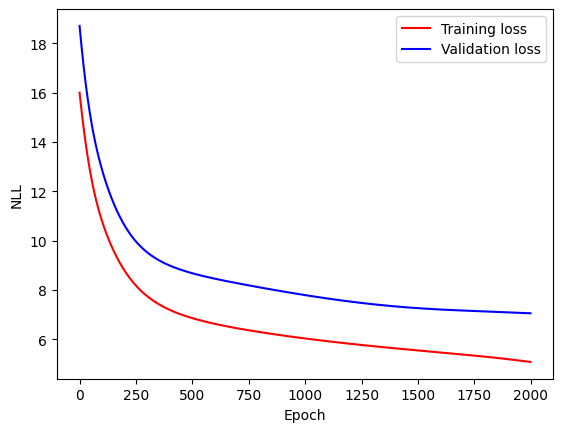

AssertionError: 

In [ ]:
# Veamos la primera secuencia en el test set
inputs, targets = test_set[1]

# One-hot encode el input y el target
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Init el hidden state con ceros
hidden_state = np.zeros((hidden_size, 1))

# Hacemos el pase forward para evalular nuestra secuencia
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print("Secuencia Input:")
print(inputs)

print("Secuencia Target:")
print(targets)

print("Secuencia Predicha:")
print([idx_to_word[np.argmax(output)] for output in outputs])

# Graficamos la perdida
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

with tick.marks(10):        
    assert compare_lists_by_percentage(targets, [idx_to_word[np.argmax(output)] for output in outputs], 65)

#### Preguntas

Ya hemos visto el funcionamiento general de nuestra red RNN, viendo las gráficas de arriba, **responda** lo siguiente dentro de esta celda

* ¿Qué interpretación le da a la separación de las graficas de training y validation?
  * La brecha creciente entre las curvas de training y validación indica que el modelo aprende más del conjunto de entrenamiento y comienza a sobreajustarse, pues la pérdida de validación disminuye más lento.
* ¿Cree que es un buen modelo basado solamente en el loss?
  * Basado solo en la loss, el modelo logra reducir eficazmente el error, pero la diferencia sugiere que podría no generalizar óptimamente.
* ¿Cómo deberían de verse esas gráficas en un modelo ideal?
  * En un modelo ideal ambas curvas descenderían de manera paralela y cercana, mostrando bajo error tanto en entrenamiento como en validación sin una brecha significativa.

## Parte 2 - Construyendo una Red Neuronal LSTM 

**Créditos:** La segunda parte de este laboratorio está tomado y basado en uno de los laboratorios dados dentro del curso de "Deep Learning" de Jes Frellsen (DeepLearningDTU)


Consideren leer el siguiente blog para mejorar el entendimiento de este tema: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

La RNN estándar enfrenta un problema de gradientes que desaparecen, lo que dificulta la retención de memoria en secuencias más largas. Para hacer frente a estos desafíos, se introdujeron algunas variantes. 

Los dos tipos principales son la celda de memoria a corto plazo (LSTM) y la unidad recurrente cerrada (GRU), las cuales demuestran una capacidad mejorada para conservar y utilizar la memoria en pasos de tiempo posteriores. 

En este ejercicio, nuestro enfoque estará en LSTM, pero los principios aprendidos aquí también se pueden aplicar fácilmente para implementar GRU.

Recordemos una de las imagenes que vimos en clase

<img src="https://www.researchgate.net/profile/Savvas-Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg" alt="LSTM" />

*Crédito de imagen al autor, imagen tomada de "Designing neural network based decoders for surface codes" de Savvas Varsamopoulos*


Recordemos que la "celula" de LST contiene tres tipos de gates, input, forget y output gate. La salida de una unidad LSTM está calculada por las siguientes funciones, donde  $\sigma = softmax$. Entonces tenemos la input gate $i$, la forget gate $f$ y la output gate $o$

* $i = \sigma ( W^i [h_{t-1}, x_t])$
* $f = \sigma ( W^f [h_{t-1},x_t])$
* $o = \sigma ( W^o [h_{t-1},x_t])$

Donde $W^i, W^f, W^o$ son las matrices de pesos aplicada a cada aplicadas a una matriz contatenada $h_{t-1}$ (hidden state vector) y $x_t$ (input vector) para cada respectiva gate $h_{t-1}$, del paso previo junto con el input actual $x_t$ son usados para calcular una memoria candidata $g$

* $g = tanh( W^g [h_{t-1}, x_t])$

El valor de la memoria $c_t$ es actualizada como

$c_t = c_{t-1} \circ f + g \circ i$

donde $c_{t-1}$ es la memoria previa, y $\circ$ es una multiplicacion element-wise (recuerden que este tipo de multiplicación en numpy es con *)

La salida $h_t$ es calculada como

$h_t = tanh(c_t) \circ o$

y este se usa para tanto la salida del paso como para el siguiente paso, mientras $c_t$ es exclusivamente enviado al siguiente paso. Esto hace $c_t$ una memoria feature, y no es usado directamente para caluclar la salida del paso actual.

### Iniciando una Red LSTM

De forma similar a lo que hemos hecho antes, necesitaremos implementar el paso forward, backward y un ciclo de entrenamiento. Pero ahora usaremos LSTM con NumPy. Más adelante veremos como es que esto funciona con PyTorch. 

In [48]:
np.random.seed(seed_)

# Tamaño del hidden state concatenado más el input
z_size = hidden_size + vocab_size 

def init_lstm(hidden_size, vocab_size, z_size):
    """
    Initializes our LSTM network.
    Init LSTM
    
    Args:
     hidden_size: Dimensiones del hidden state
     vocab_size: Dimensiones de nuestro vocabulario
     z_size: Dimensiones del input concatenado 
    """

    # Aprox 1 linea para empezar la matriz de pesos de la forget gate
    # Recuerden que esta debe empezar con numeros aleatorios
    # W_f = np.random.randn
    # YOUR CODE HERE
    W_f = np.random.randn(hidden_size, z_size)
    
    # Bias del forget gate
    b_f = np.zeros((hidden_size, 1))

    # Aprox 1 linea para empezar la matriz de pesos de la input gate
    # Recuerden que esta debe empezar con numeros aleatorios
    # YOUR CODE HERE
    W_i = np.random.randn(hidden_size, z_size)
    
    # Bias para input gate
    b_i = np.zeros((hidden_size, 1))

    # Aprox 1 linea para empezar la matriz de pesos para la memoria candidata
    # Recuerden que esta debe empezar con numeros aleatorios
    # YOUR CODE HERE
    W_g = np.random.randn(hidden_size, z_size)
    
    # Bias para la memoria candidata
    b_g = np.zeros((hidden_size, 1))

    # Aprox 1 linea para empezar la matriz de pesos para la output gate
    # YOUR CODE HERE
    W_o = np.random.randn(hidden_size, z_size)
    
    # Bias para la output gate
    b_o = np.zeros((hidden_size, 1))


    # Aprox 1 linea para empezar la matriz que relaciona el hidden state con el output
    # YOUR CODE HERE
    W_v = np.random.randn(vocab_size, hidden_size)
    
    # Bias
    b_v = np.zeros((vocab_size, 1))
    
    # Init pesos ortogonalmente (https://arxiv.org/abs/1312.6120)
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_g = init_orthogonal(W_g)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)

    return W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v

params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

In [49]:
with tick.marks(5):        
    assert check_hash(params[0], ((50, 54), -28071.583543573637))
    
with tick.marks(5):        
    assert check_hash(params[1], ((50, 54), -6337.520066952928))
    
with tick.marks(5):        
    assert check_hash(params[2], ((50, 54), -13445.986473992281))
    
with tick.marks(5):        
    assert check_hash(params[3], ((50, 54), 2276.1116210911564))
    
with tick.marks(5):        
    assert check_hash(params[4], ((4, 50), -201.28961326044097))

### Forward

Vamos para adelante con LSTM, al igual que previamente necesitamos implementar las funciones antes mencionadas

In [50]:
def forward(inputs, h_prev, C_prev, p):
    """
    Arguments:
    x: Input data en el paso "t", shape (n_x, m)
    h_prev: Hidden state en el paso "t-1", shape (n_a, m)
    C_prev: Memoria en el paso "t-1", shape (n_a, m)
    p: Lista con pesos y biases, contiene:
                        W_f:  Pesos de la forget gate, shape (n_a, n_a + n_x)
                        b_f: Bias de la forget gate, shape (n_a, 1)
                        W_i: Pesos de la update gate, shape (n_a, n_a + n_x)
                        b_i: Bias de la update gate, shape (n_a, 1)
                        W_g: Pesos de la primer "tanh", shape (n_a, n_a + n_x)
                        b_g: Bias de la primer "tanh", shape (n_a, 1)
                        W_o: Pesos de la output gate, shape (n_a, n_a + n_x)
                        b_o: Bias de la output gate, shape (n_a, 1)
                        W_v: Pesos de la matriz que relaciona el hidden state con el output, shape (n_v, n_a)
                        b_v: Bias que relaciona el hidden state con el output, shape (n_v, 1)
    Returns:
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s: Lista de tamaño m conteniendo los calculos de cada paso forward
    outputs: Predicciones en el paso "t", shape (n_v, m)
    """
    
    # Validar las dimensiones
    assert h_prev.shape == (hidden_size, 1)
    assert C_prev.shape == (hidden_size, 1)

    # Desempacar los parametros
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p
    
    # Listas para calculos de cada componente en LSTM
    x_s, z_s, f_s, i_s,  = [], [] ,[], []
    g_s, C_s, o_s, h_s = [], [] ,[], []
    v_s, output_s =  [], [] 
    
    # Agregar los valores iniciales 
    h_s.append(h_prev)
    C_s.append(C_prev)
    
    for x in inputs:

        # Aprox 1 linea para concatenar el input y el hidden state
        # z = np.row.stack(...)
        # YOUR CODE HERE
        z = np.vstack((h_s[-1], x)) 
        z_s.append(z)
        
        # Aprox 1 linea para calcular el forget gate
        # Hint: recuerde usar sigmoid
        # f = 
        # YOUR CODE HERE
        f = sigmoid(np.dot(W_f, z) + b_f) 
        f_s.append(f)
        
        # Calculo del input gate
        i = sigmoid(np.dot(W_i, z) + b_i)
        i_s.append(i)
        
        # Calculo de la memoria candidata
        g = tanh(np.dot(W_g, z) + b_g)
        g_s.append(g)
        
        # Aprox 1 linea para calcular el estado de la memoria
        # C_prev = 
        # YOUR CODE HERE
        C_prev = f * C_s[-1] + i * g
        C_s.append(C_prev)
        
        # Aprox 1 linea para el calculo de la output gate
        # Hint: recuerde usar sigmoid
        # o = 
        # YOUR CODE HERE
        o = sigmoid(np.dot(W_o, z) + b_o)
        o_s.append(o)
        
        # Calculate hidden state
        # Aprox 1 linea para el calculo del hidden state
        # h_prev =
        # YOUR CODE HERE
        h_prev = o * tanh(C_prev)
        h_s.append(h_prev)

        # Calcular logits
        v = np.dot(W_v, h_prev) + b_v
        v_s.append(v)
        
        # Calculo de output (con softmax)
        output = softmax(v)
        output_s.append(output)

    return z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, output_s


In [51]:
# Obtener la primera secuencia para probar
inputs, targets = test_set[1]

# One-hot encode del input y target
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Init hidden state con ceros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]

print("Secuencia Input:")
print(inputs)

print("Secuencia Target:")
print(targets)

print("Secuencia Predicha:")
print([idx_to_word[np.argmax(output)] for output in outputs])


with tick.marks(5):        
    assert check_hash(outputs, ((22, 4, 1), 980.1651308051631))

Secuencia Input:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Secuencia Target:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Secuencia Predicha:
['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS', 'EOS', 'EOS', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']


### Backward

Ahora de reversa, al igual que lo hecho antes, necesitamos implementar el paso de backward


In [56]:
def backward(z, f, i, g, C, o, h, v, outputs, targets, p = params):
    """
    Arguments:
    z: Input concatenado como una lista de tamaño m.
    f: Calculos del forget gate como una lista de tamaño m.
    i: Calculos del input gate como una lista de tamaño m.
    g: Calculos de la memoria candidata como una lista de tamaño m.
    C: Celdas estado como una lista de tamaño m+1.
    o: Calculos del output gate como una lista de tamaño m.
    h: Calculos del Hidden State como una lista de tamaño m+1.
    v: Calculos del logit como una lista de tamaño m.
    outputs: Salidas como una lista de tamaño m.
    targets: Targets como una lista de tamaño m.
    p: Lista con pesos y biases, contiene:
                        W_f:  Pesos de la forget gate, shape (n_a, n_a + n_x)
                        b_f: Bias de la forget gate, shape (n_a, 1)
                        W_i: Pesos de la update gate, shape (n_a, n_a + n_x)
                        b_i: Bias de la update gate, shape (n_a, 1)
                        W_g: Pesos de la primer "tanh", shape (n_a, n_a + n_x)
                        b_g: Bias de la primer "tanh", shape (n_a, 1)
                        W_o: Pesos de la output gate, shape (n_a, n_a + n_x)
                        b_o: Bias de la output gate, shape (n_a, 1)
                        W_v: Pesos de la matriz que relaciona el hidden state con el output, shape (n_v, n_a)
                        b_v: Bias que relaciona el hidden state con el output, shape (n_v, 1)
    Returns:
    loss: crossentropy loss para todos los elementos del output
    grads: lista de gradientes para todos los elementos en p
    """

    # Desempacar parametros
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # Init gradientes con cero
    W_f_d = np.zeros_like(W_f)
    b_f_d = np.zeros_like(b_f)

    W_i_d = np.zeros_like(W_i)
    b_i_d = np.zeros_like(b_i)

    W_g_d = np.zeros_like(W_g)
    b_g_d = np.zeros_like(b_g)

    W_o_d = np.zeros_like(W_o)
    b_o_d = np.zeros_like(b_o)

    W_v_d = np.zeros_like(W_v)
    b_v_d = np.zeros_like(b_v)
    
    # Setear la proxima unidad y hidden state con ceros
    dh_next = np.zeros_like(h[0])
    dC_next = np.zeros_like(C[0])
        
    # Para la perdida
    loss = 0
    
    # Iteramos en reversa los outputs
    for t in reversed(range(len(outputs))):
        
        # Aprox 1 linea para calcular la perdida con cross entropy
        # loss += ...
        # YOUR CODE HERE
        loss += -np.sum(targets[t] * np.log(outputs[t] + 1e-12))
        
        # Obtener el hidden state del estado previo
        C_prev= C[t-1]
        
        # Compute the derivative of the relation of the hidden-state to the output gate
        # Calculo de las derivadas en relacion del hidden state al output gate
        dv = np.copy(outputs[t])
        dv[np.argmax(targets[t])] -= 1

        # Aprox 1 linea para actualizar la gradiente de la relacion del hidden-state al output gate
        # W_v_d += 
        # YOUR CODE HERE
        W_v_d += np.dot(dv, h[t+1].T)
        b_v_d += dv

        # Calculo de la derivada del hidden state y el output gate
        dh = np.dot(W_v.T, dv)        
        dh += dh_next
        do = dh * tanh(C[t])
        # Aprox 1 linea para calcular la derivada del output
        # do = ..
        # Hint: Recuerde multiplicar por el valor previo de do (el de arriba)
        # YOUR CODE HERE
        do = sigmoid(o[t], derivative=True) * do
        
        # Actualizacion de las gradientes con respecto al output gate
        W_o_d += np.dot(do, z[t].T)
        b_o_d += do

        # Calculo de las derivadas del estado y la memoria candidata g
        dC = np.copy(dC_next)
        dC += dh * o[t] * tanh(tanh(C[t]), derivative=True)
        dg = dC * i[t]
        # Aprox 1 linea de codigo para terminar el calculo de dg
        # YOUR CODE HERE
        dg = (1 - g[t]**2) * dg
        
        # Actualización de las gradientes con respecto de la mem candidata
        W_g_d += np.dot(dg, z[t].T)
        b_g_d += dg

        # Compute the derivative of the input gate and update its gradients
        # Calculo de la derivada del input gate y la actualización de sus gradientes
        di = dC * g[t]
        di = sigmoid(i[t], True) * di
        # Aprox 2 lineas para el calculo de los pesos y bias del input gate
        # W_i_d += 
        # b_i_d +=
        # YOUR CODE HERE
        W_i_d += np.dot(di, z[t].T)
        b_i_d += di

        # Calculo de las derivadas del forget gate y actualización de sus gradientes
        df = dC * C_prev
        df = sigmoid(f[t]) * df
        # Aprox 2 lineas para el calculo de los pesos y bias de la forget gate
        # W_f_d += 
        # b_f_d +=
        # YOUR CODE HERE
        W_f_d += np.dot(df, z[t].T)
        b_f_d += df

        # Calculo de las derivadas del input y la actualizacion de gradientes del hidden state previo
        dz = (np.dot(W_f.T, df)
             + np.dot(W_i.T, di)
             + np.dot(W_g.T, dg)
             + np.dot(W_o.T, do))
        dh_prev = dz[:hidden_size, :]
        dC_prev = f[t] * dC
        
    grads= W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d
    
    # Recorte de gradientes
    grads = clip_gradient_norm(grads)
    
    return loss, grads

In [57]:
# Realizamos un backward pass para probar
loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

print(f"Perdida obtenida:{loss}")

with tick.marks(5):        
    assert(check_scalar(loss, '0x53c34f25'))

Perdida obtenida:30.548871762964705


AssertionError: 

### Training

Ahora intentemos entrenar nuestro LSTM básico. Esta parte es muy similar a lo que ya hicimos previamente con la RNN

In [58]:
# Hyper parametros
num_epochs = 500

# Init una nueva red
z_size = hidden_size + vocab_size # Tamaño del hidden concatenado + el input
params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

# Init hidden state como ceros
hidden_state = np.zeros((hidden_size, 1))

# Perdida
training_loss, validation_loss = [], []

# Iteramos cada epoca
for i in range(num_epochs):
    
    # Perdidas
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # Para cada secuencia en el validation set
    for inputs, targets in validation_set:
        
        # One-hot encode el inpyt y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Init hidden state y la unidad de estado como ceros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Backward 
        loss, _ = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # Actualizacion de la perdida
        epoch_validation_loss += loss
    
    # Para cada secuencia en el training set
    for inputs, targets in training_set:
        
        # One-hot encode el inpyt y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Init hidden state y la unidad de estado como ceros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Backward
        loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # Actualización de parametros
        params = update_parameters(params, grads, lr=1e-1)
        
        # Actualizacion de la perdida
        epoch_training_loss += loss
                
    # Guardar la perdida para ser graficada
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Mostrar la perdida cada 5 epocas
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

Epoch 0, training loss: 11.78654458018811, validation loss: 17.998828244634012
Epoch 10, training loss: 4.906659400281213, validation loss: 5.970274480596549
Epoch 20, training loss: 3.7261114259806334, validation loss: 5.428418737559244
Epoch 30, training loss: 3.850304168390219, validation loss: 6.50096041181074
Epoch 40, training loss: 3.8006401787711184, validation loss: 6.710530859317392
Epoch 50, training loss: 3.6720952688763466, validation loss: 6.695264142058322
Epoch 60, training loss: 3.670950990592858, validation loss: 6.846772696643188
Epoch 70, training loss: 3.7380882816011978, validation loss: 7.0609689320933935
Epoch 80, training loss: 3.768142759265067, validation loss: 7.010503208213535
Epoch 90, training loss: 3.8094006942802787, validation loss: 6.844423578975558
Epoch 100, training loss: 3.8763628201155003, validation loss: 6.820608139520511
Epoch 110, training loss: 3.851599408741709, validation loss: 6.562848837031805
Epoch 120, training loss: 3.6635021890741597

Secuencia Input:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Secuencia Target:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Secuencia Predicha:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS', 'EOS', 'EOS']


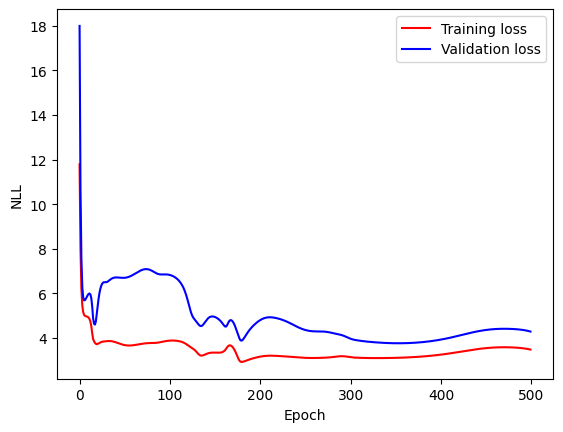

In [59]:
# Obtener la primera secuencia del test set
inputs, targets = test_set[1]

# One-hot encode el input y el target
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Init hidden state como ceros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward 
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

print("Secuencia Input:")
print(inputs)

print("Secuencia Target:")
print(targets)

print("Secuencia Predicha:")
print([idx_to_word[np.argmax(output)] for output in outputs])

# Graficar la perdida en training y validacion
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

#### Preguntas

**Responda** lo siguiente dentro de esta celda

* ¿Qué modelo funcionó mejor? ¿RNN tradicional o el basado en LSTM? ¿Por qué?
  *El modelo LSTM funcionó mejor, pues alcanzó pérdidas de entrenamiento y validación notablemente más bajas que la RNN tradicional. Gracias a sus compuertas, retiene información relevante y evita el desvanecimiento del gradiente, lo que le permite aprender dependencias de largo alcance.
* Observen la gráfica obtenida arriba, ¿en qué es diferente a la obtenida a RNN? ¿Es esto mejor o peor? ¿Por qué?
  *La curva de LSTM converge mucho más rápido y a valores de NLL menores, aunque muestra oscilaciones por la actualización de memoria; en cambio, la RNN desciende de forma más suave pero se atasca en pérdidas más altas. Esta oscilación controlada es mejor, pues indica que el LSTM explora más eficientemente el espacio de parámetros y no se estanca.
* ¿Por qué LSTM puede funcionar mejor con secuencias largas?
  *Porque su célula de memoria y compuertas de olvido/actualización regulan el flujo de gradientes, preservando información relevante en pasos lejanos y mitigando el efecto de gradientes que se diluyen o explotan. Esto le permite modelar dependencias a largo plazo que la RNN tradicional no puede retener.

## Parte 3 - Red Neuronal LSTM con PyTorch 

Ahora que ya hemos visto el funcionamiento paso a paso de tanto RNN tradicional como LSTM. Es momento de usar PyTorch. Para esta parte usaremos el mismo dataset generado al inicio. Así mismo, usaremos un ciclo de entrenamiento similar al que hemos usado previamente. 

En la siguiente parte (sí, hay una siguiente parte &#x1F913;) usaremos otro tipo de dataset más formal

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Aprox 1-3 lineas de codigo para declarar una capa LSTM
        # self.lstm = 
        # Hint: Esta tiene que tener el input_size del tamaño del vocabulario,
        #     debe tener 50 hidden states (hidden_size)
        #     una layer
        #     y NO (False) debe ser bidireccional 
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Layer de salida (output)
        self.l_out = nn.Linear(in_features=50,
                            out_features=vocab_size,
                            bias=False)
        
    def forward(self, x):
        # RNN regresa el output y el ultimo hidden state
        x, (h, c) = self.lstm(x)
        
        # Aplanar la salida para una layer feed forward
        x = x.view(-1, self.lstm.hidden_size)
        
        # layer de output 
        x = self.l_out(x)
        
        return x

net = Net()
print(net)

In [ ]:
# Hyper parametros
num_epochs = 500

# Init una nueva red
net = Net()

# Aprox 2 lineas para definir la función de perdida y el optimizador
# criterion = # Use CrossEntropy
# optimizer = # Use Adam con lr=3e-4
# YOUR CODE HERE
raise NotImplementedError()

# Perdida
training_loss, validation_loss = [], []

# Iteramos cada epoca
for i in range(num_epochs):
    
    # Perdidas
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # NOTA 1
    net.eval()
        
    # Para cada secuencia en el validation set
    for inputs, targets in validation_set:
        
        # One-hot encode el inpyt y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convertir el input a un tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convertir el target a un tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Aprox 1 linea para el Forward 
        # outputs = 
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Aprox 1 linea para calcular la perdida
        # loss =
        # Hint: Use el criterion definido arriba
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Actualizacion de la perdida
        epoch_validation_loss += loss.detach().numpy()
    
    # NOTA 2
    net.train()
    
    # Para cada secuencia en el training set
    for inputs, targets in training_set:
        
        # One-hot encode el inpyt y el target
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convertir el input a un tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convertir el target a un tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Aprox 1 linea para el Forward 
        # outputs = 
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Aprox 1 linea para calcular la perdida
        # loss =
        # Hint: Use el criterion definido arriba
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Aprox 3 lineas para definir el backward
        # optimizer.
        # loss.
        # optimizer.
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Actualizacion de la perdida
        epoch_training_loss += loss.detach().numpy()
        
    # Guardar la perdida para ser graficada
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Mostrar la perdida cada 5 epocas
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


In [ ]:

with tick.marks(5):        
    assert compare_numbers(new_representation(training_loss[-1]), "3c3d", '0x1.28f5c28f5c28fp-2')
    
with tick.marks(5):        
    assert compare_numbers(new_representation(validation_loss[-1]), "3c3d", '0x1.28f5c28f5c28fp-2')

In [ ]:
# Obtener la primera secuencia del test set
inputs, targets = test_set[1]

# One-hot encode el input y el target
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]

# Convertir el input a un tensor
inputs_one_hot = torch.Tensor(inputs_one_hot)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convertir el target a un tensor
targets_idx = torch.LongTensor(targets_idx)


# Aprox 1 linea para el Forward 
# outputs = 
# YOUR CODE HERE
raise NotImplementedError()

print("Secuencia Input:")
print(inputs)

print("Secuencia Target:")
print(targets)

print("Secuencia Predicha:")
print([idx_to_word[np.argmax(output)] for output in outputs])

# Graficar la perdida en training y validacion
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

#### Preguntas

**Responda** lo siguiente dentro de esta celda

* Compare las graficas obtenidas en el LSTM "a mano" y el LSTM "usando PyTorch, ¿cuál cree que es mejor? ¿Por qué?
* Compare la secuencia target y la predicha de esta parte, ¿en qué parte falló el modelo?
* ¿Qué sucede en el código donde se señala "NOTA 1" y "NOTA 2"? ¿Para qué son necesarias estas líneas?

## Parte 4 - Segunda Red Neuronal LSTM con PyTorch 

Para esta parte será un poco menos guiada, por lo que se espera que puedan generar un modelo de Red Neuronal con LSTM para solventar un problema simple. Lo que se evaluará es la métrica final, y solamente se dejarán las generalidades de la implementación. El objetivo de esta parte, es dejar que ustedes exploren e investiguen un poco más por su cuenta. 

En este parte haremos uso de las redes LSTM pero para predicción de series de tiempo. Entonces lo que se busca es que dado un mes y un año, se debe predecir el número de pasajeros en unidades de miles. Los datos a usar son de 1949 a 1960.

Basado del blog "LSTM for Time Series Prediction in PyTorch" de Adrian Tam.

In [ ]:
# Seed all
import torch
import random
import numpy as np


random.seed(seed_)
np.random.seed(seed_)
torch.manual_seed(seed_)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_)
    torch.cuda.manual_seed_all(seed_)  # Multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
import pandas as pd

url_data = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
dataset = pd.read_csv(url_data)
dataset.head(10)

In [ ]:
# Dibujemos la serie de tiempo
time_series = dataset[["Passengers"]].values.astype('float32')

plt.plot(time_series)
plt.show()

Esta serie de tiempo comprende 144 pasos de tiempo. El gráfico indica claramente una tendencia al alza y hay patrones periódicos en los datos que corresponden al período de vacaciones de verano. Por lo general, se recomienda "eliminar la tendencia" de la serie temporal eliminando el componente de tendencia lineal y normalizándolo antes de continuar con el procesamiento. Sin embargo, por simplicidad de este ejercicios, vamos a omitir estos pasos.

Ahora necesitamos dividir nuestro dataset en training, validation y test set. A diferencia de otro tipo de datasets, cuando se trabaja en este tipo de proyectos, la división se debe hacer sin "revolver" los datos. Para esto, podemos hacerlo con NumPy

In [ ]:
# En esta ocasion solo usaremos train y test, validation lo omitiremos para simpleza del ejercicio
# NO CAMBIEN NADA DE ESTA CELDA POR FAVOR
p_train=0.8
p_test=0.2

# Definimos el tamaño de las particiones
num_train = int(len(time_series)*p_train)
num_test = int(len(time_series)*p_test)


# Dividir las secuencias en las particiones
train = time_series[:num_train]
test = time_series[num_train:]

El aspecto más complicado es determinar el método por el cual la red debe predecir la serie temporal. Por lo general, la predicción de series temporales se realiza en función de una ventana. En otras palabras, recibe datos del tiempo t1 al t2, y su tarea es predecir para el tiempo t3 (o más adelante). El tamaño de la ventana, denotado por w, dicta cuántos datos puede considerar el modelo al hacer la predicción. Este parámetro también se conoce como **look back period** (período retrospectivo).

Entonces, creemos una función para obtener estos datos, dado un look back period. Además, debemos asegurarnos de transformar estos datos a tensores para poder ser usados con PyTorch.

Esta función está diseñada para crear ventanas en la serie de tiempo mientras predice un paso de tiempo en el futuro inmediato. Su propósito es convertir una serie de tiempo en un tensor con dimensiones (muestras de ventana, pasos de tiempo, características). Dada una serie de tiempo con t pasos de tiempo, puede producir aproximadamente (t - ventana + 1) ventanas, donde "ventana" denota el tamaño de cada ventana. Estas ventanas pueden comenzar desde cualquier paso de tiempo dentro de la serie de tiempo, siempre que no se extiendan más allá de sus límites.

Cada ventana contiene múltiples pasos de tiempo consecutivos con sus valores correspondientes, y cada paso de tiempo puede tener múltiples características. Sin embargo, en este conjunto de datos específico, solo hay una función disponible.

La elección del diseño garantiza que tanto la "característica" como el "objetivo" tengan la misma forma. Por ejemplo, para una ventana de tres pasos de tiempo, la "característica" corresponde a la serie de tiempo de t-3 a t-1, y el "objetivo" cubre los pasos de tiempo de t-2 a t. Aunque estamos principalmente interesados en predecir t+1, la información de t-2 a t es valiosa durante el entrenamiento.

Es importante tener en cuenta que la serie temporal de entrada se representa como una matriz 2D, mientras que la salida de la función `create_timeseries_dataset()` será un tensor 3D. Para demostrarlo, usemos lookback=1 y verifiquemos la forma del tensor de salida en consecuencia.

In [ ]:
import torch

def create_timeseries_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

# EL VALOR DE LB SÍ LO PUEDEN CAMBIAR SI LO CONSIDERAN NECESARIO
lb = 4
X_train, y_train = create_timeseries_dataset(train, lookback=lb)
#X_validation, y_validation = create_timeseries_dataset(validation, lookback=lb)
X_test, y_test = create_timeseries_dataset(test, lookback=lb)

print(X_train.shape, y_train.shape)
#print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

Ahora necesitamos crear una clase que definirá nuestro modelo de red neuronal con LSTM. Noten que acá solo se dejaran las firmas de las funciones necesarias, ustedes deberán decidir que arquitectura con LSTM implementar, con la finalidad de superar cierto threshold de métrica de desempeño mencionado abajo.

In [ ]:
import torch.nn as nn

# NOTA: Moví el numero de iteraciones para que no se borre al ser evaluado
# Pueden cambiar el número de epocas en esta ocasión con tal de llegar al valor de la metrica de desempeño
# n_epochs = 3000
# YOUR CODE HERE
raise NotImplementedError()

class CustomModelLSTM(nn.Module):
    def __init__(self):
        # YOUR CODE HERE
        raise NotImplementedError()
    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()
        return x

La función nn.LSTM() produce una tupla como salida. El primer elemento de esta tupla consiste en los hidden states generados, donde cada paso de tiempo de la entrada tiene su correspondiente hidden state. El segundo elemento contiene la memoria y los hidden states de la unidad LSTM, pero no se usan en este contexto particular.

La capa LSTM se configura con la opción `batch_first=True` porque los tensores de entrada se preparan en la dimensión de (muestra de ventana, pasos de tiempo, características). Con esta configuración, se crea un batch tomando muestras a lo largo de la primera dimensión.

Para generar un único resultado de regresión, la salida de los estados ocultos se procesa aún más utilizando una capa fully connected. Dado que la salida de LSTM corresponde a un valor para cada paso de tiempo de entrada, se debe seleccionar solo la salida del último paso de tiempo.

In [ ]:
import torch.optim as optim
import torch.utils.data as data

# NOTEN QUE ESTOY PONIENDO DE NUEVO LOS SEEDS PARA SER CONSTANTES
random.seed(seed_)
np.random.seed(seed_)
torch.manual_seed(seed_)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_)
    torch.cuda.manual_seed_all(seed_)  # Multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
############
 
model = CustomModelLSTM()
# Optimizador y perdida
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# Observen como podemos también definir un DataLoader de forma snecilla
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)
 

# Perdidas
loss_train = []
loss_test = []

# Iteramos sobre cada epoca
for epoch in range(n_epochs):
    # Colocamos el modelo en modo de entrenamiento
    model.train()
    
    # Cargamos los batches
    for X_batch, y_batch in loader:
        # Obtenemos una primera prediccion
        y_pred = model(X_batch)
        # Calculamos la perdida
        loss = loss_fn(y_pred, y_batch)
        # Reseteamos la gradiente a cero
        #   sino la gradiente de previas iteraciones se acumulará con las nuevas
        optimizer.zero_grad()
        # Backprop
        loss.backward()
        # Aplicar las gradientes para actualizar los parametros del modelo
        optimizer.step()
        
    # Validación cada 100 epocas
    if epoch % 100 != 0 and epoch != n_epochs-1:
        continue
    # Colocamos el modelo en modo de evaluación
    model.eval()
    
    # Deshabilitamos el calculo de gradientes
    with torch.no_grad():
        # Prediccion
        y_pred = model(X_train)
        # Calculo del RMSE - Root Mean Square Error
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        # Prediccion sobre validation
        y_pred = model(X_test)
        # Calculo del RMSE para validation
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        loss_train.append(train_rmse)
        loss_test.append(test_rmse)
        
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

In [ ]:
# Visualización del rendimiento
epoch = np.arange(len(loss_train))
plt.figure()
plt.plot(epoch, loss_train, 'r', label='Training',)
plt.plot(epoch, loss_test, 'b', label='Test')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

In [ ]:
# Graficamos
with torch.no_grad():
    # Movemos las predicciones de train para graficar
    train_plot = np.ones_like(time_series) * np.nan
    # Prediccion de train
    y_pred = model(X_train)
    # Extraemos los datos solo del ultimo paso
    y_pred = y_pred[:, -1, :]
    train_plot[lb : num_train] = model(X_train)[:, -1, :]
    # Movemos las predicciones de test
    test_plot = np.ones_like(time_series) * np.nan
    test_plot[num_train + lb : len(time_series)] = model(X_test)[:, -1, :]

    
plt.figure()
plt.plot(time_series, label="Serie Original")
plt.plot(train_plot, c='r', label="Serie Train")
plt.plot(test_plot, c='g', label="Serie Test")
plt.xlabel('Paso en el Tiempo'), plt.ylabel('Pasajeros')
plt.legend()
plt.show()

**Nota:** Lo que se estará evaluando es el RMSE tanto en training como en test. Se evaluará que en training sea **menor a 22**, mientras que en testing sea **menor a 70**.

In [ ]:
float(loss_test[len(loss_test)-1])
float(test_rmse)
loss_train

with tick.marks(7):        
    assert loss_train[-1] < 22 
    
with tick.marks(7):        
    assert train_rmse < 22 
    
with tick.marks(7):        
    assert loss_test[-1] < 70 
    
with tick.marks(7):        
    assert test_rmse < 70 
    

In [ ]:

print()
print("La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio")
tick.summarise_marks() # 
